In [1]:
# equilibrage des classes
from sklearn.linear_model import SGDClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
# from imblearn.over_sampling import SMOTE

# librairies générales
from collections import Counter
import functions as fct
import warnings
from joblib import dump, load
import timeit
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
# from sklearn.calibration import calibration_curve, CalibratedClassifierCV


from scipy.stats import randint
from scipy.stats import uniform

In [2]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


  # Import des données

In [3]:
data = pd.read_csv("../01_DATA/data_for_modelling.csv")
liste_quali = pd.read_csv("../01_DATA/liste_quali.csv")
prev_app = pd.read_csv('../01_DATA/previous_application.csv')
print(data.shape)
print(liste_quali.shape)


(307177, 127)
(12, 2)


In [4]:


def load_joblibs(job_dir):
    """Permet de charger les encodeurs et les imputeurs depuis le dossier en argument"""
    mean_imputer = load(job_dir+'/mean_imputer.joblib')
    regexp = 'label_encoder-'
    label_encoders = {}
    for file_name in os.listdir(os.getcwd()+'/joblib'):
        if re.match(regexp, file_name):
            feature = file_name.split('-')[1].split('.')[0]
            label_encoders[feature] = load(job_dir+'/'+file_name)
    return label_encoders, mean_imputer



In [5]:
label_encoders, mean_imputer = load_joblibs('./joblib')


 # Data pour test rapide

In [6]:
# data = data.sample(frac=0.1)


 # Préparation des données

In [7]:
# mise en forme liste variables qualitatives
# retrait colonne 'unnamed'
liste_quali.drop(columns=['Unnamed: 0'], inplace=True)
# transformation en liste et retrait de la variable 'target'
liste_quali = liste_quali['0'].tolist()


In [8]:
# l'index des lignes correspond à l'ID de la demande de prêt en cours
data = data.set_index('SK_ID_CURR')

# Séparation de la target des données d'apprentissage
target = data.TARGET
data = data.drop(columns=['TARGET'], axis=1)
data[liste_quali] = data[liste_quali].astype('object')


In [9]:
# séparation des données en jeu d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(
    data, target, train_size=0.8, random_state=10)
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)


X_train : (245741, 125)
y_train : (245741,)
X_test : (61436, 125)
y_test : (61436,)


In [10]:
print("Notre échantillon d'entraînement contient %d individus avec %d variables" %
      (X_train.shape[0], X_train.shape[1]))


Notre échantillon d'entraînement contient 245741 individus avec 125 variables


 # Preprocessing

In [11]:
from sklearn.impute import SimpleImputer
# # mise en place du pipeline pour les données qualitatives
quali_pipeline = make_pipeline(SimpleImputer(strategy='constant', fill_value='-1'))

# mise en place du pipeline pour les données quantitatives
quanti_pipeline = make_pipeline(StandardScaler())
liste_quanti = [
    feature for feature in data.columns if feature not in liste_quali]

# mise en place du preprocessor
preprocessor = make_column_transformer((quanti_pipeline, liste_quanti),
                                        (quali_pipeline, liste_quali))


In [12]:
set_config(display='diagram')
preprocessor


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                  'AMT_CREDIT', 'AMT_ANNUITY',
                                  'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLISH',
                                  'REGION_RATING_CLIENT_W_CITY',
                                  'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2',
                                  'EX...
                                  'BUREAU_MONTHS_BALANCE_SIZE_SUM', ...]),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='-1',
                                                                strategy='constant'))]),
                                 ['FLAG_WORK_PHONE', 'FLAG_PHONE',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_3',
                                  'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_13',
                                  'FLAG_DOCUMENT_16', 'NAME_CONTRACT_TYPE',
                                  'CODE_GENDER', 'FLAG_OWN_CAR',
                                  'EMERGENCYSTATE_MODE'])])

In [13]:
y_train.value_counts()


0.0    225960
1.0     19781
Name: TARGET, dtype: int64

 # Equilibrage des classes
 la target est déséquilibrée (92% de prêts accordés) => il faut donc rééquilibrer les classes pour ne pas fausser l'apprentissage du modèle.

 Plusieurs options existent :
 - sampling aléatoire dans la classe sur-représentée de façon à arriver à 50-50.
     * ++ = très simple à mettre en place
     * -- = va conduire à un petit jeu d'entrainement : 39 370 individus contre 243 612 actuellement
 - génération d'individus fictifs à partir des données de la classe sous-représentée (SMOTE)
     * ++ = permet d'avoir un jeu de donnée plus grand
     * -- = il n'est pas recommandé de générer + de 25% de 'fausses' données
 - combinaison des deux méthodes précédentes
     * ++ : permet de limiter les risques de SMOTE tout en augmentant la taille du jeu d'entrainement
 - utilisation de class_weight quand cette option est disponible dans les modèles
     * ++ : très simple d'utilisation
     * -- : ne va pas compenser le manque d'information potentiel de la classe sous-représentée

 ## Equilibrage via SMOTE + under sampling

In [14]:
counter_init = Counter(y_train)
print(counter_init)
ratio = counter_init[1]/counter_init[0]
print("ratio initial 1/0 : {:.3f}".format(ratio))


Counter({0.0: 225960, 1.0: 19781})
ratio initial 1/0 : 0.088


 - SMOTENC : Si on se fixe comme limite de ne générer que 25% de données en plus dans la classe minoritaire via SMOTE, cela revient à se fixer une sampling_strategy de 0.087*1.25 = 0.11
 - Under-sampling : l'objectif est d'arriver à 50-50 dans la répartition des classes, sampling_strategy = 1

In [15]:
oversampling = SMOTENC(sampling_strategy=.11, categorical_features=[0, 8], random_state=10)
undersampling = RandomUnderSampler(sampling_strategy=1, random_state=10)

steps = [('over', oversampling), ('under', undersampling)]
pipeline_balanced = Pipeline(steps=steps)

X_train_balanced, y_train_balanced = pipeline_balanced.fit_resample(
    X_train, y_train)

counter_balanced = Counter(y_train_balanced)
print(counter_balanced)
print(len(y_train_balanced))
ratio = counter_balanced[1]/counter_balanced[0]
print('ratio SMOTE : {:.3f}'.format(counter_balanced[1] / counter_init[0]))
print("ratio final 1/0 : {:.3f}".format(ratio))


Counter({0.0: 24855, 1.0: 24855})
49710
ratio SMOTE : 0.110
ratio final 1/0 : 1.000


In [16]:
delta_1 = counter_balanced[1] - counter_init[1]
print("création de {} individus (+{:.2f} % par rapport au jeu de données initial) pour la classe sous-représentée".format(delta_1, 100*delta_1/len(y_train)))
print("sous-échantillonnage de {} individus ({:.2f} %) appartenant à la classe majoritaire".format(
    counter_balanced[0], 100*counter_balanced[0]/counter_init[0]))
print("le jeu de données est désormais réparti à {:.2f} %".format(100*counter_balanced[0]/len(y_train_balanced)),
      "pour la classe majoritaire et {:.2f} % pour la classe minoritaire".format(100*counter_balanced[1]/len(y_train_balanced)))


création de 5074 individus (+2.06 % par rapport au jeu de données initial) pour la classe sous-représentée
sous-échantillonnage de 24855 individus (11.00 %) appartenant à la classe majoritaire
le jeu de données est désormais réparti à 50.00 % pour la classe majoritaire et 50.00 % pour la classe minoritaire


 ## Equilibrage via class_weight
 calcul du poids à attribuer aux catégories

In [17]:
# count: Dictionnaire contant le nombre de cas positifs et le nombre de cas négatifs
count = Counter(y_train)
# weight_positive: Poids à accorder aux cas positifs
weight_positive = count[0]/count[1]
print("Il y à %.2f cas positifs pour 1 cas négatif" % weight_positive)
weight_positive = int(round(weight_positive))


Il y à 11.42 cas positifs pour 1 cas négatif


 # FONCTIONS

In [18]:


def affichage_resultats(model, run, X_train, y_train, X_test, y_test, resultats, beta=12):
    start = timeit.default_timer()
    # entrainement du modèle
    model.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start
    # Extraction du seuil optimal de décision
    # y_proba: Probabilités de défaut de paiement prédites pour les données d'entraînement
    y_proba = model.predict_proba(X_train)[:, 1]
    # fpr, tpr, thresholds: False Positive Rate, True Positive Rate, Seuils, pour les données d'entraînement
    fpr, tpr, thresholds = roc_curve(y_train, y_proba, pos_label=1)
    # best_tresh: Seuil optimal pour discriminer les candidatures = point d'inflexion de la courbe ROC
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    print("Seuil optimal de discrimination:%.3f\n" % best_thresh)
    # prédiction du modèle sur le jeu de test
    y_pred = model.predict(X_test)
    # extraction des probabilités
    y_proba = model.predict_proba(X_test)[:, 1]
    # extraction des variables false positive rate, true positive rate et thresholds
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_proba)
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat_pourcent = 100 * conf_mat / len(y_test)

    # Nombre de prêt accordés / refusés dans la base de test
    nb_pret_accorde = y_test.value_counts()[0]
    nb_pret_refuse = y_test.value_counts()[1]

    # Calcul des scores
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    precision = precision_score(y_true=y_test, y_pred=y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred)
    auc_score = auc(x=fpr, y=tpr)
    fbeta = fbeta_score(y_true=y_test, y_pred=y_pred, beta=beta)
    custom = custom_metric(y_pred, y_test)

    # Affichage du rapport de classification
    print(classification_report(y_true=y_test, y_pred=y_pred))
    # Affichage des scores
    print('-'*10)
    print("f1-score : {:.3f}".format(f1))
    print("fbeta-score : {:.3f}".format(fbeta))
    print("precision : {:.3f}".format(precision))
    print("recall : {:.3f}".format(recall))
    print("auc : {:.3f}".format(auc_score))
    print("custom score : {:.3f}".format(custom))

    nom_run = run + "_" + str(model[1])

    # Stockage des résultats
    resultats.loc[nom_run, "AUC"] = auc_score
    resultats.loc[nom_run, "Recall"] = recall
    resultats.loc[nom_run, 'Precision'] = precision
    resultats.loc[nom_run, "F1"] = f1
    resultats.loc[nom_run, "Fbeta"] = fbeta
    resultats.loc[nom_run, "seuil_opt"] = best_thresh
    resultats.loc[nom_run, "durée_calculs_s"] = elapsed
    resultats.loc[nom_run, "custom_score"] = custom

    # affichage de la courbe ROC et de la matrice de confusion
    my_cmap = sns.diverging_palette(20, 220, as_cmap=True)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.title(
        "Receiver Operating Characteristic\nmodel : {}\n".format(model[1]))
    plt.text(0.6, 0.4, "AUC=%.3f\nRecall=%.3f\nPrecision=%.3f\nF1=%.3f\nFbeta=%.3f" % (
        auc_score, recall, precision, f1, fbeta))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.subplot(1, 2, 2)
    axes = plt.gca()
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap=my_cmap)
    plt.title("Matrice de confusion\n\n1 = refus du crédit ({})\n0 = acceptation du crédit ({})\n".format(
        nb_pret_refuse, nb_pret_accorde))
    axes.xaxis.set_ticks_position('top')
    axes.xaxis.set_label_position('top')
    axes.set_frame_on('False')
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    return resultats



 # Metrique metier
 Dans notre situation deux types d'erreurs sont possibles :
 - accorder un prêt à un individu qui ne le remboursera pas (erreur de type II) => risque de perte d'argent +++ pour la banque
 - refuser un prêt à un individu qui aurait pu le rembourser (erreur de type I) => risque de gain moins important pour la banque

 La première erreur se mesure avec le recall (taux de vrais positifs) et la deuxième avec la précision (proportion de prédictions correctes parmis les points prédits +)

 Calculons dans un premier temps les caractéristiques d'un prêt moyen sur la base des précédentes demandes de prêt accordés (table previous_application), ce qui permettra de quantifier combien fait perdre une erreur de type II et quel gain n'est pas fait par une erreur de type I.

 *Je fais l'hypothèse (pessimiste) que lorsqu'il y a un défaut de paiement l'intégralité du prêt n'est pas remboursé*


In [19]:
def mensualite(duree, montant, taux):
    '''
    duree : en années
    montant : montant total du pret accordé
    taux : taux d'interet du prêt
    '''
    m = montant * (taux/12) / (1 - (1 + taux/12)**(-12*duree))
    return m



In [20]:
# Days 365.243 values -> nan
prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)


In [21]:
filtre_approved = prev_app.NAME_CONTRACT_STATUS == 'Approved'

taux_moyen = prev_app[filtre_approved].RATE_INTEREST_PRIMARY.mean()
montant_moyen = prev_app[filtre_approved].AMT_CREDIT.mean()
duree_moyenne_jours = (- (prev_app[filtre_approved].DAYS_DECISION -
                       prev_app[filtre_approved].DAYS_TERMINATION)).mean()
duree_moyenne_ans = duree_moyenne_jours / 365.25

mensualite_moyenne = mensualite(
    duree=duree_moyenne_ans, montant=montant_moyen, taux=taux_moyen)
gain_si_rembourse = 12 * duree_moyenne_ans * mensualite_moyenne - montant_moyen
perte_si_non_rembourse = 12 * duree_moyenne_ans * mensualite_moyenne
ratio_perte_gain = perte_si_non_rembourse / gain_si_rembourse

print('taux_moyen : {:.3f}'.format(taux_moyen))
print('montant moyen : {:.2f}'.format(montant_moyen))
print('durée moyenne (ans): {:.2f}'.format(duree_moyenne_ans))
print('mensualite moyenne : {:.0f}'.format(mensualite_moyenne))
print('-'*10)
print('gain si pret remboursé : {:.0f}'.format(gain_si_rembourse))
print('perte si pret non remboursé : {:.0f}'.format(perte_si_non_rembourse))
print('ratio perte/gain : {:.2f}'.format(ratio_perte_gain))



taux_moyen : 0.188
montant moyen : 202564.18
durée moyenne (ans): 0.84
mensualite moyenne : 21837
----------
gain si pret remboursé : 18070
perte si pret non remboursé : 220634
ratio perte/gain : 12.21


In [22]:
print("Le coût d'un défaut de paiement (erreur de type II) représente {:.0f} fois le gain non réalisé par une erreur de type I".format(
    ratio_perte_gain))


Le coût d'un défaut de paiement (erreur de type II) représente 12 fois le gain non réalisé par une erreur de type I


 Il s'agit donc bien de maximiser le recall et la précision, en accordant plus d'importance au recall qui permet de minimiser les faux négatifs qui coutent très chers à la banque. La metrique F-Beta permet d'attribuer un poids plus grand au recall via le choix du paramètre Beta et ainsi maximiser le nombre de vrais positifs tout en minimisant les faux negatifs et les faux positifs.

 Le paramètre Beta est donx fixé à 12 de façon à favoriser la maximisation du recall et ainsi éviter au maximum les erreurs de type II.

In [23]:
def custom_metric(y_pred, y_true):
    '''
    metrique basée sur les caractéristiques d'un prêt moyen, à savoir :
    gain si remboursé = 18069.6
    perte si prêt non remboursé = 220633.7
    score = TN * gain - FP * gain - FN * perte + 0 * TP
    plus le score est grand, plus la banque gagne de l'argent
    '''
    df = pd.DataFrame(y_pred, y_true).reset_index()
    df.columns = ['Target', 'y_pred']

    masque_TN = (df.Target == 0) & (df.y_pred == 0)
    # masque_TP = (df.Target == 1) & (df.y_pred == 1)
    masque_FP = (df.Target == 0) & (df.y_pred == 1)
    masque_FN = (df.Target == 1) & (df.y_pred == 0)

    score = gain_si_rembourse * (masque_TN.sum() - masque_FP.sum()) - perte_si_non_rembourse * masque_FN.sum()

    return score

custom_score = make_scorer(custom_metric)

 # Selection du modèle
 ## Dummy_classifier

In [24]:
resultats_choix_model = pd.DataFrame(
    columns=["AUC", "Recall", "Precision", "F1", "Fbeta", 'custom_score', "seuil_opt", "durée_calculs_s"])


Seuil optimal de discrimination:1.080

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.00      0.00      0.00      5013

    accuracy                           0.92     61436
   macro avg       0.46      0.50      0.48     61436
weighted avg       0.84      0.92      0.88     61436

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.500
custom score : -86498640.525


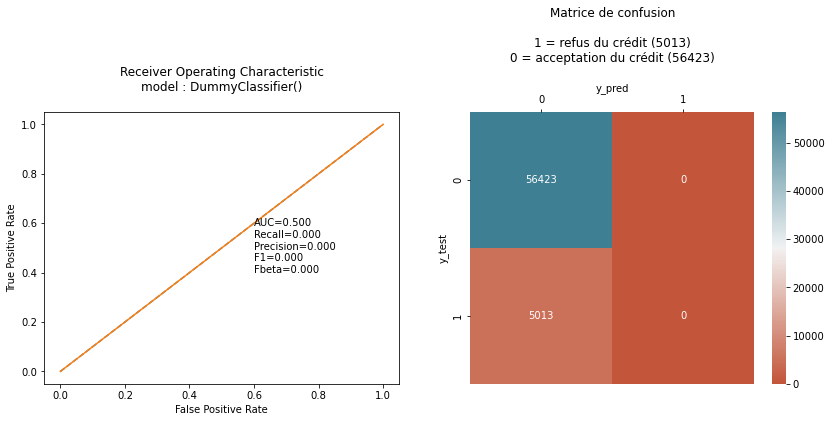

In [25]:
model = DummyClassifier()
model = make_pipeline(preprocessor, model)
resultats_choix_model = affichage_resultats(
    model, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


Seuil optimal de discrimination:1.500

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56402
         1.0       0.00      0.00      0.00      5034

    accuracy                           0.92     61436
   macro avg       0.46      0.50      0.48     61436
weighted avg       0.84      0.92      0.88     61436

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.500


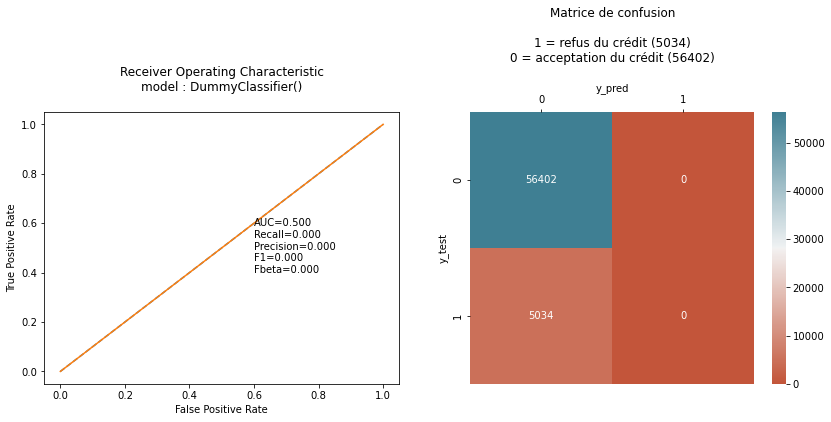

In [25]:
model = DummyClassifier()
model = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    model, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


Seuil optimal de discrimination:1.080

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56402
         1.0       0.00      0.00      0.00      5034

    accuracy                           0.92     61436
   macro avg       0.46      0.50      0.48     61436
weighted avg       0.84      0.92      0.88     61436

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.500


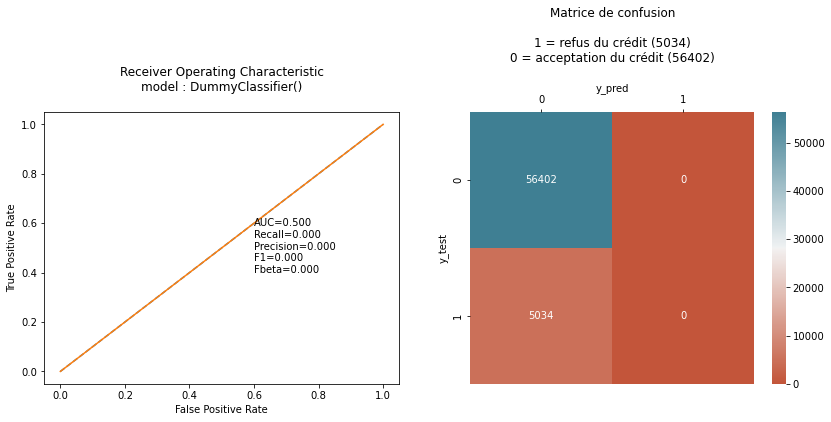

In [26]:
model = DummyClassifier()
model = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    model, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


In [27]:
resultats_choix_model


,AUC,Recall,Precision,F1,Fbeta,seuil_opt,durée_calculs_s
not_balanced_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.08041,1.587164
balanced_SMOTE_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.5,0.571892
balanced_class_weight_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.08041,1.69326


 ## Regression logistique
 comme la feature selection a écarté les variables redondantes, il n'est pas nécessaire de mettre en place une régularisation dans le cadre de la regression logistique
 ### jeu de données non équilibré

Seuil optimal de discrimination:0.077

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56402
         1.0       0.43      0.02      0.03      5034

    accuracy                           0.92     61436
   macro avg       0.67      0.51      0.49     61436
weighted avg       0.88      0.92      0.88     61436

----------
f1-score : 0.032
fbeta-score : 0.017
precision : 0.430
recall : 0.016
auc : 0.753


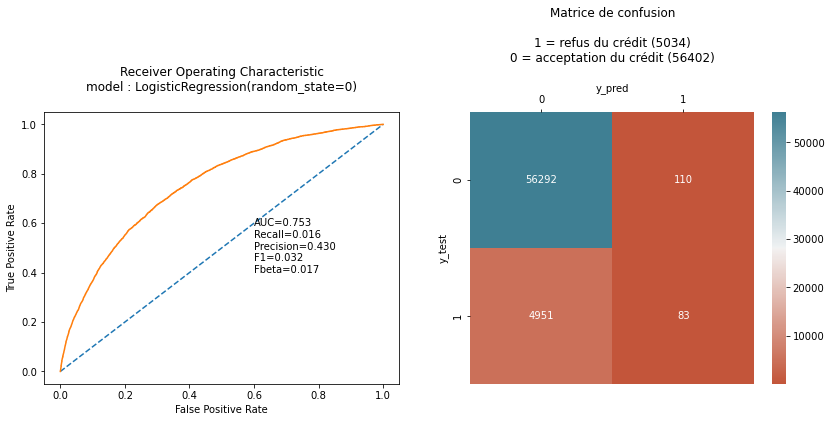

In [28]:

model = LogisticRegression(random_state=10)
lr = make_pipeline(preprocessor, model)
# lr.fit(X_train, y_train)

resultats_choix_model = affichage_resultats(
    lr, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


 ### jeu de données équilibré (smote + undersampling)

Seuil optimal de discrimination:0.500

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56402
         1.0       0.17      0.68      0.27      5034

    accuracy                           0.69     61436
   macro avg       0.56      0.69      0.54     61436
weighted avg       0.90      0.69      0.76     61436

----------
f1-score : 0.267
fbeta-score : 0.666
precision : 0.166
recall : 0.680
auc : 0.752


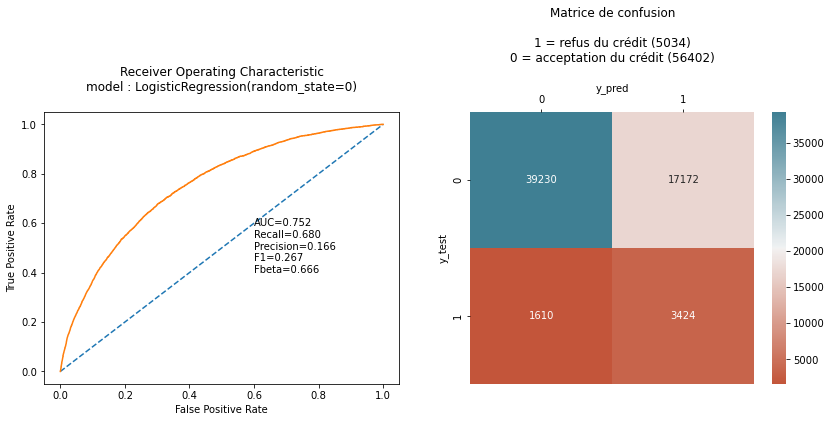

In [29]:
model = LogisticRegression(random_state=10)
lr = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lr, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


 ### Equilibrage du jeu de données via class_weight

Seuil optimal de discrimination:0.465

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     56402
         1.0       0.17      0.66      0.27      5034

    accuracy                           0.71     61436
   macro avg       0.56      0.69      0.54     61436
weighted avg       0.89      0.71      0.77     61436

----------
f1-score : 0.270
fbeta-score : 0.648
precision : 0.170
recall : 0.661
auc : 0.753


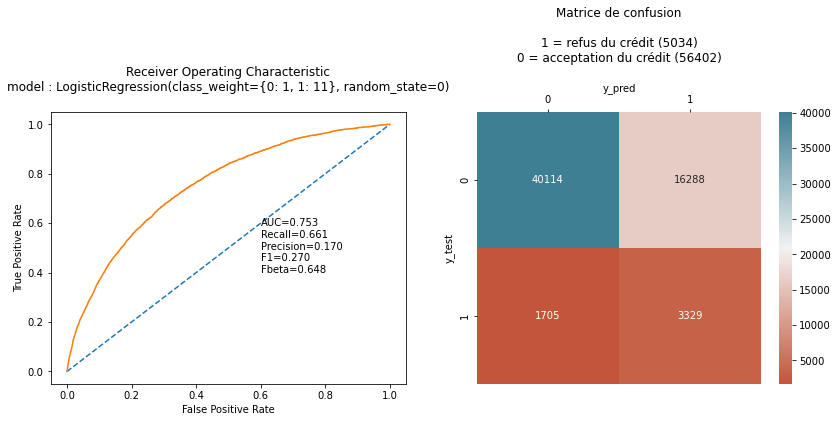

In [30]:
model = LogisticRegression(random_state=10, class_weight={
                           0: 1, 1: weight_positive})
lr = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lr, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


In [31]:
resultats_choix_model


,AUC,Recall,Precision,F1,Fbeta,seuil_opt,durée_calculs_s
not_balanced_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.08041,1.587164
balanced_SMOTE_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.5,0.571892
balanced_class_weight_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,1.08041,1.69326
not_balanced_LogisticRegression(random_state=0),0.752853,0.016488,0.430052,0.031758,0.016598,0.076926,7.731335
balanced_SMOTE_LogisticRegression(random_state=0),0.75215,0.680175,0.166246,0.267187,0.665976,0.499698,1.411115
"balanced_class_weight_LogisticRegression(class_weight={0: 1, 1: 11}, random_state=0)",0.752914,0.661303,0.1697,0.27009,0.64835,0.465376,6.962225


 # SGD Classifier
 ## jeu de données non équilibré

Seuil optimal de discrimination:0.075

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56402
         1.0       0.30      0.01      0.01      5034

    accuracy                           0.92     61436
   macro avg       0.61      0.50      0.48     61436
weighted avg       0.87      0.92      0.88     61436

----------
f1-score : 0.013
fbeta-score : 0.007
precision : 0.303
recall : 0.007
auc : 0.689


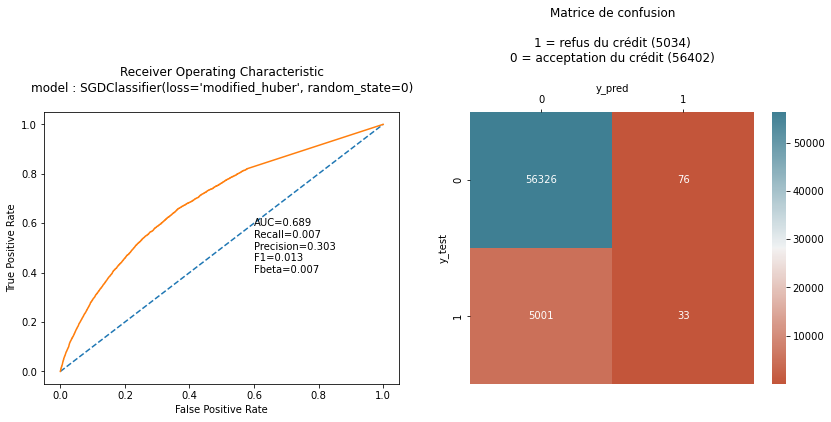

In [32]:

model = SGDClassifier(random_state=10, loss='modified_huber')
sgd = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    sgd, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


 ## jeu de données équilibré (SMOTE + undersampling)

Seuil optimal de discrimination:0.495

              precision    recall  f1-score   support

         0.0       0.95      0.67      0.78     56402
         1.0       0.14      0.61      0.23      5034

    accuracy                           0.66     61436
   macro avg       0.55      0.64      0.51     61436
weighted avg       0.88      0.66      0.74     61436

----------
f1-score : 0.228
fbeta-score : 0.594
precision : 0.140
recall : 0.608
auc : 0.689


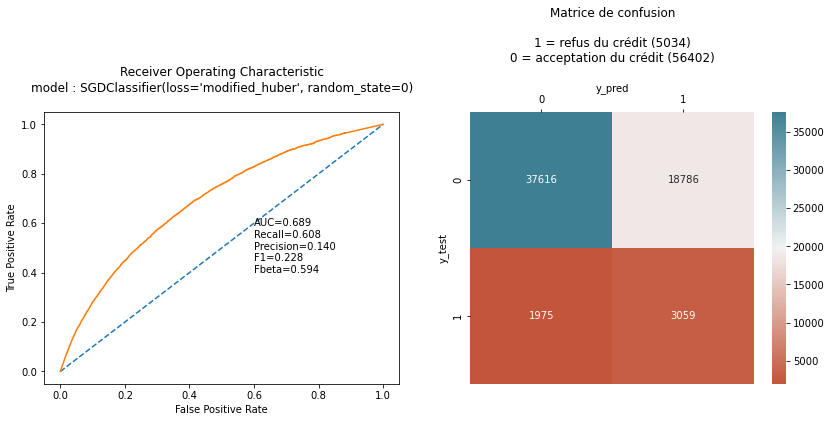

In [33]:
model = SGDClassifier(random_state=10, loss='modified_huber')
sgd = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    sgd, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


 ## Jeu de données équilibré (class_weight)

Seuil optimal de discrimination:0.075

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56402
         1.0       0.30      0.01      0.01      5034

    accuracy                           0.92     61436
   macro avg       0.61      0.50      0.48     61436
weighted avg       0.87      0.92      0.88     61436

----------
f1-score : 0.013
fbeta-score : 0.007
precision : 0.303
recall : 0.007
auc : 0.689


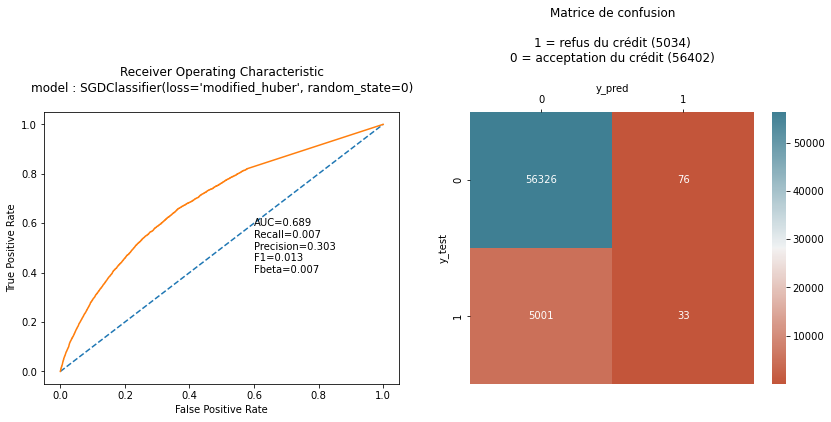

In [34]:
model = SGDClassifier(random_state=10, loss='modified_huber')
sgd = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    sgd, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


 ## Random Forest
 ### Jeu de données non équilibré

Seuil optimal de discrimination:0.470

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56402
         1.0       0.68      0.00      0.01      5034

    accuracy                           0.92     61436
   macro avg       0.80      0.50      0.48     61436
weighted avg       0.90      0.92      0.88     61436

----------
f1-score : 0.008
fbeta-score : 0.004
precision : 0.679
recall : 0.004
auc : 0.717


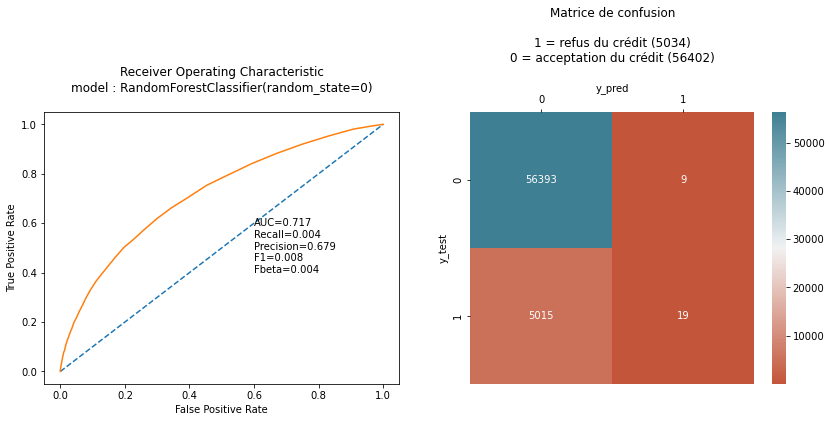

In [35]:

model = RandomForestClassifier(random_state=10)
rf = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    rf, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


 ### jeu de données équilibré (SMOTE + undersampling)

Seuil optimal de discrimination:0.580

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83     56402
         1.0       0.18      0.62      0.27      5034

    accuracy                           0.73     61436
   macro avg       0.57      0.68      0.55     61436
weighted avg       0.89      0.73      0.79     61436

----------
f1-score : 0.274
fbeta-score : 0.611
precision : 0.176
recall : 0.622
auc : 0.742


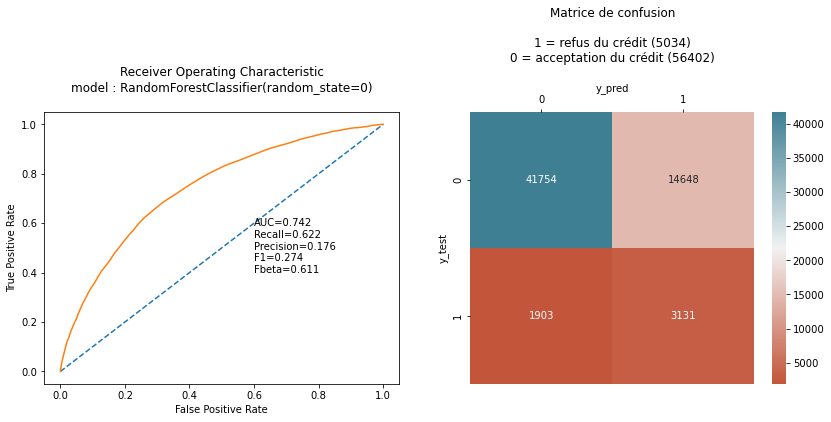

In [36]:
model = RandomForestClassifier(random_state=10)
rf = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    rf, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


 ### Equilibrage du jeu de données via class_weight

Seuil optimal de discrimination:0.440

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56402
         1.0       0.60      0.00      0.00      5034

    accuracy                           0.92     61436
   macro avg       0.76      0.50      0.48     61436
weighted avg       0.89      0.92      0.88     61436

----------
f1-score : 0.005
fbeta-score : 0.002
precision : 0.600
recall : 0.002
auc : 0.729


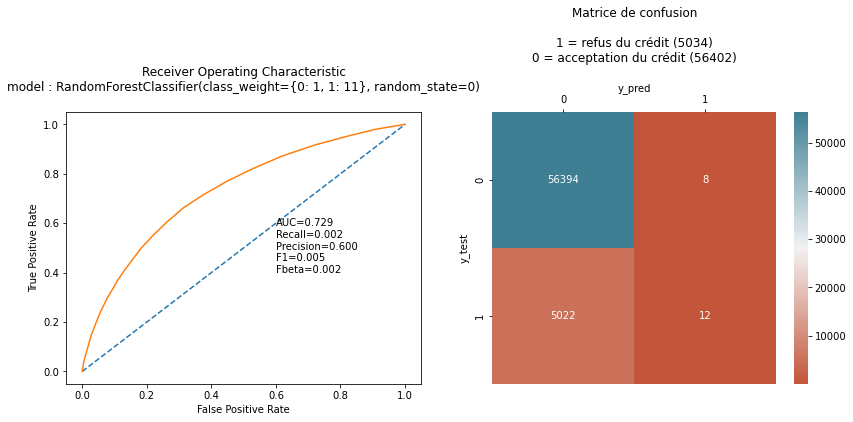

In [37]:
model = RandomForestClassifier(random_state=10, class_weight={
                               0: 1, 1: weight_positive})
rf = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    rf, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


 ## LightGBM
 ### Jeu de données non équilibré

Seuil optimal de discrimination:0.084

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56402
         1.0       0.49      0.03      0.05      5034

    accuracy                           0.92     61436
   macro avg       0.70      0.51      0.50     61436
weighted avg       0.88      0.92      0.88     61436

----------
f1-score : 0.052
fbeta-score : 0.028
precision : 0.486
recall : 0.028
auc : 0.767


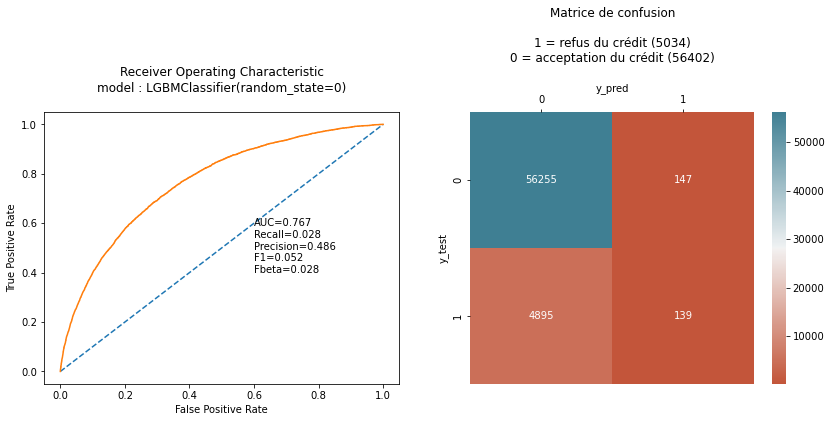

In [38]:
model = LGBMClassifier(random_state=10)
lgbm = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lgbm, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)


 ### Jeu de données équilibré (SMOTE + undersampling)

Seuil optimal de discrimination:0.479

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     56402
         1.0       0.19      0.62      0.29      5034

    accuracy                           0.75     61436
   macro avg       0.57      0.69      0.57     61436
weighted avg       0.89      0.75      0.80     61436

----------
f1-score : 0.286
fbeta-score : 0.609
precision : 0.186
recall : 0.619
auc : 0.764


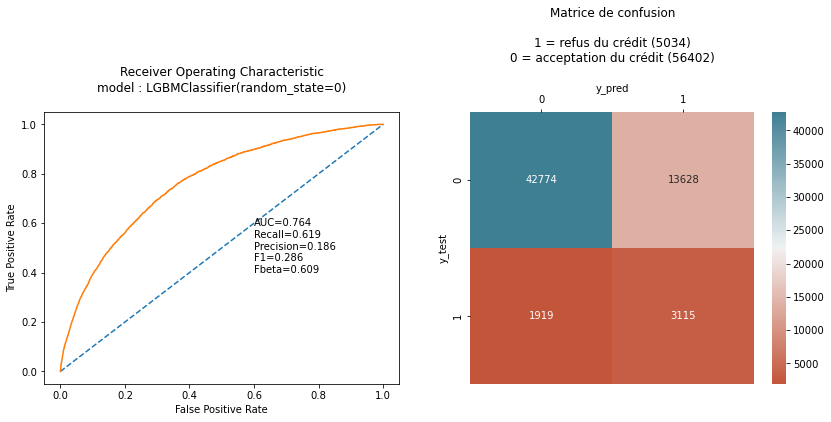

In [39]:
model = LGBMClassifier(random_state=10)
lgbm = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lgbm, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)


 ### Jeu de données équilibré (class_weight)

Seuil optimal de discrimination:0.468

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83     56402
         1.0       0.18      0.66      0.29      5034

    accuracy                           0.73     61436
   macro avg       0.57      0.70      0.56     61436
weighted avg       0.90      0.73      0.79     61436

----------
f1-score : 0.286
fbeta-score : 0.646
precision : 0.182
recall : 0.658
auc : 0.767


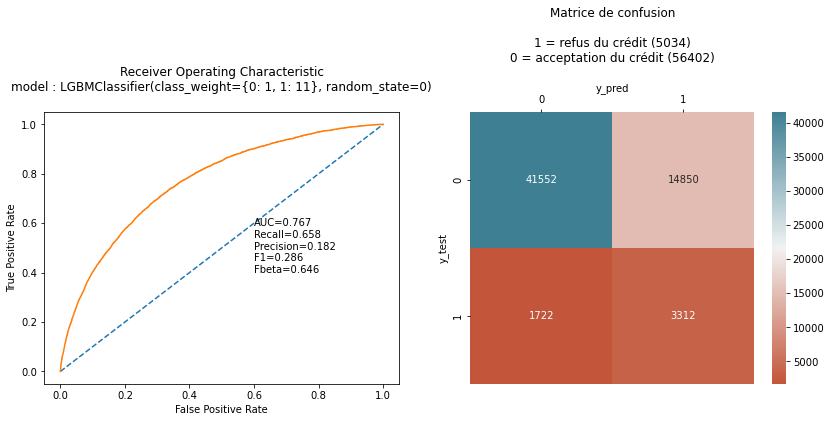

In [40]:
model = LGBMClassifier(random_state=10, class_weight={0: 1, 1: weight_positive})
lgbm = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lgbm, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)


In [41]:
resultats_choix_model.sort_values(by="Fbeta", ascending=False)


,AUC,Recall,Precision,F1,Fbeta,seuil_opt,durée_calculs_s
balanced_SMOTE_LogisticRegression(random_state=0),0.75215,0.680175,0.166246,0.267187,0.665976,0.499698,1.411115
"balanced_class_weight_LogisticRegression(class_weight={0: 1, 1: 11}, random_state=0)",0.752914,0.661303,0.1697,0.27009,0.64835,0.465376,6.962225
"balanced_class_weight_LGBMClassifier(class_weight={0: 1, 1: 11}, random_state=0)",0.767493,0.657926,0.182359,0.285566,0.646302,0.46751,9.048586
balanced_SMOTE_RandomForestClassifier(random_state=0),0.741847,0.621971,0.176107,0.274493,0.611297,0.58,25.211795
balanced_SMOTE_LGBMClassifier(random_state=0),0.763953,0.618792,0.186048,0.286082,0.609023,0.479196,2.743595
"balanced_SMOTE_SGDClassifier(loss='modified_huber', random_state=0)",0.688559,0.607668,0.140032,0.227613,0.593988,0.494964,5.777603
not_balanced_LGBMClassifier(random_state=0),0.766734,0.027612,0.486014,0.052256,0.027793,0.08427,8.612531
not_balanced_LogisticRegression(random_state=0),0.752853,0.016488,0.430052,0.031758,0.016598,0.076926,7.731335
"not_balanced_SGDClassifier(loss='modified_huber', random_state=0)",0.689121,0.006555,0.302752,0.012833,0.0066,0.075266,12.619718
"balanced_class_weight_SGDClassifier(loss='modified_huber', random_state=0)",0.689121,0.006555,0.302752,0.012833,0.0066,0.075266,9.884


 Les deux meilleurs classifieurs sont la LogisticRegression et LGBMClassifier, à chaque fois avec des données équilibrées. Je vais donc chercher à optimiser ces deux classifieurs en testant les deux méthodes d'équilibrage des données

 # Optimisation des hyperparamètres
 # metric = fbeta
 ## SMOTE+undersampling
 ### LogisticRegression

In [149]:
# création du tableau qui va stocker les résultats des différentes optimisations
resultats_optimisation = pd.DataFrame(
    columns=['best_params', 'AUC', 'Recall', 'Precision', 'F1', 'Fbeta', 'custom_score', 'seuil_opt', 'duree_calculs_s', 'duree_refit'])

# configuration de la fonction d'évaluation
fbeta_scorer = make_scorer(fbeta_score, beta=12)

# LogisticRegression : configuration des paramètres à tester
penalty = ['l1', 'l2', 'none']
C = uniform(loc=.0001, scale=100)
solver = ['sag', 'saga', 'lbfgs']

# LGBM : configuration des paramètres
max_depth = randint(low=5, high=15)
num_leaves = randint(low=2, high=30)  # doit être inférieur à 2*max_depth
num_iterations = randint(low=100, high=10000)
learning_rate = uniform(0.001, 10)
reg_alpha = uniform(0.001, 100)
reg_lambda = uniform(0.001, 100)
min_split_gain = uniform(0.001, 10)


In [151]:
# Fonction pour trouver les paramètres optimaux et stocker les résultats dans un tableau


def optimisation_param(model_opt, run, X_train, y_train, X_test, y_test, resultats, beta=12):
    start = timeit.default_timer()
    # entrainement du modèle
    model_opt.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start
    # Extraction du seuil optimal de décision
    # y_proba: Probabilités de défaut de paiement prédites pour les données d'entraînement
    y_proba = model_opt.predict_proba(X_train)[:, 1]
    # fpr, tpr, thresholds: False Positive Rate, True Positive Rate, Seuils, pour les données d'entraînement
    fpr, tpr, thresholds = roc_curve(y_train, y_proba, pos_label=1)
    # best_tresh: Seuil optimal pour discriminer les candidatures = point d'inflexion de la courbe ROC
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    print("Seuil optimal de discrimination:%.3f\n" % best_thresh)
    # prédiction du modèle sur le jeu de test
    y_pred = model_opt.predict(X_test)
    # extraction des probabilités
    y_proba = model_opt.predict_proba(X_test)[:, 1]
    # extraction des variables false positive rate, true positive rate et thresholds
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_proba)
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_test, y_pred)

    # Nombre de prêt accordés / refusés dans la base de test
    nb_pret_accorde = y_test.value_counts()[0]
    nb_pret_refuse = y_test.value_counts()[1]

    # Calcul des scores
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    precision = precision_score(y_true=y_test, y_pred=y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred)
    auc_score = auc(x=fpr, y=tpr)
    fbeta = fbeta_score(y_true=y_test, y_pred=y_pred, beta=beta)
    custom = custom_metric(y_pred, y_test)

    # Affichage du rapport de classification
    print(classification_report(y_true=y_test, y_pred=y_pred))
    # Affichage des scores
    print('-'*10)
    print("f1-score : {:.3f}".format(f1))
    print("fbeta-score : {:.3f}".format(fbeta))
    print("precision : {:.3f}".format(precision))
    print("recall : {:.3f}".format(recall))
    print("auc : {:.3f}".format(auc_score))
    print("custom score : {:.3f}".format(custom))

    # Stockage des résultats
    resultats.loc[run, "AUC"] = auc_score
    resultats.loc[run, "Recall"] = recall
    resultats.loc[run, 'Precision'] = precision
    resultats.loc[run, "F1"] = f1
    resultats.loc[run, "Fbeta"] = fbeta
    resultats.loc[run, "seuil_opt"] = best_thresh
    resultats.loc[run, "duree_calculs_s"] = elapsed
    resultats.loc[run, "duree_refit"] = float(model_opt.refit_time_)
    resultats.loc[run, 'best_params'] = str(model_opt.best_params_)
    resultats.loc[run, "custom_score"] = custom

    # affichage de la courbe ROC et de la matrice de confusion
    my_cmap = sns.diverging_palette(20, 220, as_cmap=True)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.title("Receiver Operating Characteristic\nmodel : {}\n".format(run))
    plt.text(0.6, 0.4, "AUC=%.3f\nRecall=%.3f\nPrecision=%.3f\nF1=%.3f\nFbeta=%.3f" % (
        auc_score, recall, precision, f1, fbeta))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.subplot(1, 2, 2)
    axes = plt.gca()
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap=my_cmap)
    plt.title("Matrice de confusion\n\n1 = refus du crédit ({})\n0 = acceptation du crédit ({})\n".format(
        nb_pret_refuse, nb_pret_accorde))
    axes.xaxis.set_ticks_position('top')
    axes.xaxis.set_label_position('top')
    axes.set_frame_on('False')
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    return resultats, model_opt


Seuil optimal de discrimination:0.500

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56402
         1.0       0.17      0.68      0.27      5034

    accuracy                           0.69     61436
   macro avg       0.56      0.69      0.54     61436
weighted avg       0.90      0.69      0.76     61436

----------
f1-score : 0.267
fbeta-score : 0.666
precision : 0.166
recall : 0.680
auc : 0.752
custom score : 43177145.172


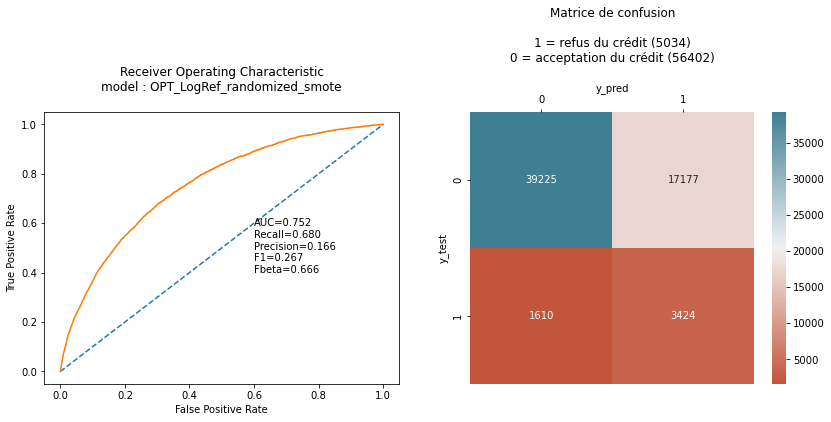

In [152]:
# test avec randomizedSearchCV
distribution_lr = {'logisticregression__penalty': penalty,
                   'logisticregression__C': C,
                   'logisticregression__solver': solver}

# configuration modèle
model = LogisticRegression(random_state=10)
lr = make_pipeline(preprocessor, model)

randomized_lr_smote = RandomizedSearchCV(
    lr, param_distributions=distribution_lr, scoring=fbeta_scorer, cv=5, random_state=10)
resultats_optimisation, randomized_lr_smote_opt = optimisation_param(
    randomized_lr_smote, "OPT_LogRef_randomized_smote", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)


In [153]:
resultats_optimisation

,best_params,AUC,Recall,Precision,F1,Fbeta,custom_score,seuil_opt,duree_calculs_s,duree_refit
OPT_LogRef_randomized_smote,"{'logisticregression__C': 13.14591524025229, '...",0.752136,0.680175,0.166206,0.267135,0.665972,43177145.172279,0.500418,209.126239,1.543597


 ### LGBM

Seuil optimal de discrimination:1.000

              precision    recall  f1-score   support

         0.0       0.95      0.49      0.65     56402
         1.0       0.11      0.73      0.20      5034

    accuracy                           0.51     61436
   macro avg       0.53      0.61      0.42     61436
weighted avg       0.89      0.51      0.61     61436

----------
f1-score : 0.198
fbeta-score : 0.708
precision : 0.115
recall : 0.734
auc : 0.622


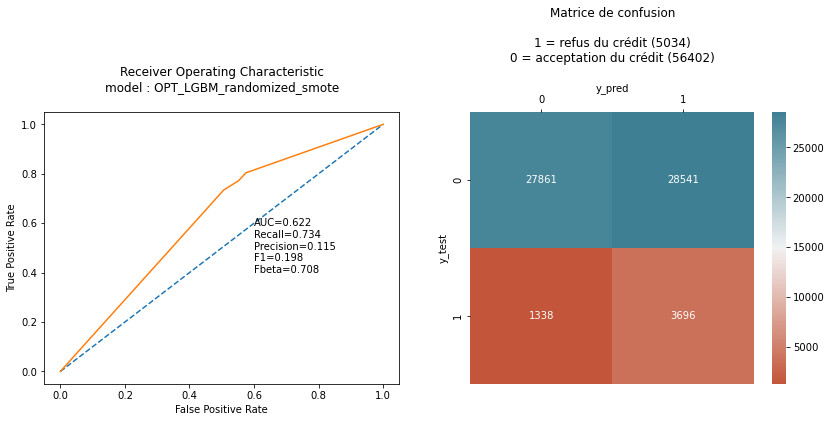

In [49]:
distribution_lgbm = {'lgbmclassifier__max_depth': max_depth,
                     'lgbmclassifier__num_leaves': num_leaves,
                     'lgbmclassifier__num_iterations': num_iterations,
                     'lgbmclassifier__learning_rate': learning_rate,
                     'lgbmclassifier__reg_alpha': reg_alpha,
                     'lgbmclassifier__reg_lambda': reg_lambda,
                     'lgbmclassifier__min_split_gain': min_split_gain}

# configuration modèle
model = LGBMClassifier(random_state=10)
lgbm = make_pipeline(preprocessor, model)

randomized_lgbm_smote = RandomizedSearchCV(
    lgbm, param_distributions=distribution_lgbm, scoring=fbeta_scorer, cv=5, random_state=10, verbose=-1, n_iter=10)
resultats_optimisation, randomized_lgbm_smote_opt = optimisation_param(
    randomized_lgbm_smote, "OPT_LGBM_randomized_smote", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)


In [50]:
resultats_optimisation


,best_params,AUC,Recall,Precision,F1,Fbeta,seuil_opt,duree_calculs_s,duree_refit
OPT_LogRef_randomized_smote,"{'logisticregression__C': 54.881450392732475, ...",0.752055,0.67799,0.165945,0.26663,0.663863,0.48037,292.989824,6.943973
OPT_LGBM_randomized_smote,{'lgbmclassifier__learning_rate': 7.5871562432...,0.621833,0.734207,0.114651,0.198331,0.707828,1.0,1031.265457,6.648723


 ## Class_weight
 ### LogisticRegression

Seuil optimal de discrimination:0.465

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     56402
         1.0       0.17      0.66      0.27      5034

    accuracy                           0.71     61436
   macro avg       0.56      0.69      0.54     61436
weighted avg       0.89      0.71      0.77     61436

----------
f1-score : 0.271
fbeta-score : 0.651
precision : 0.170
recall : 0.664
auc : 0.753


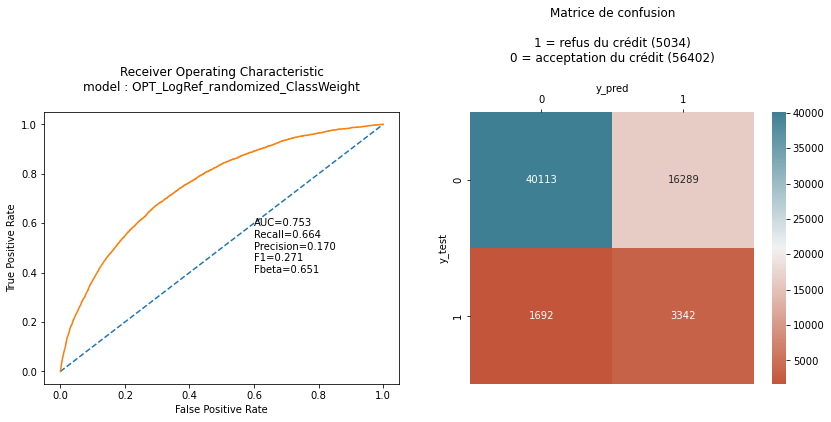

In [51]:
# configuration des paramètres à tester
distribution_lr = {'logisticregression__penalty': penalty,
                   'logisticregression__C': C,
                   'logisticregression__solver': solver}

# configuration modèle
model = LogisticRegression(random_state=10, class_weight={
                           0: 1, 1: weight_positive})
lr = make_pipeline(preprocessor, model)

randomized_lr_CW = RandomizedSearchCV(
    lr, param_distributions=distribution_lr, scoring=fbeta_scorer, cv=5, random_state=10)
resultats_optimisation, randomized_lr_CW_opt = optimisation_param(
    randomized_lr_CW, "OPT_LogRef_randomized_ClassWeight", X_train, y_train, X_test, y_test, resultats_optimisation)


 ### LGBM

Seuil optimal de discrimination:1.000

              precision    recall  f1-score   support

         0.0       0.96      0.45      0.62     56402
         1.0       0.11      0.77      0.19      5034

    accuracy                           0.48     61436
   macro avg       0.53      0.61      0.41     61436
weighted avg       0.89      0.48      0.58     61436

----------
f1-score : 0.195
fbeta-score : 0.738
precision : 0.111
recall : 0.768
auc : 0.611


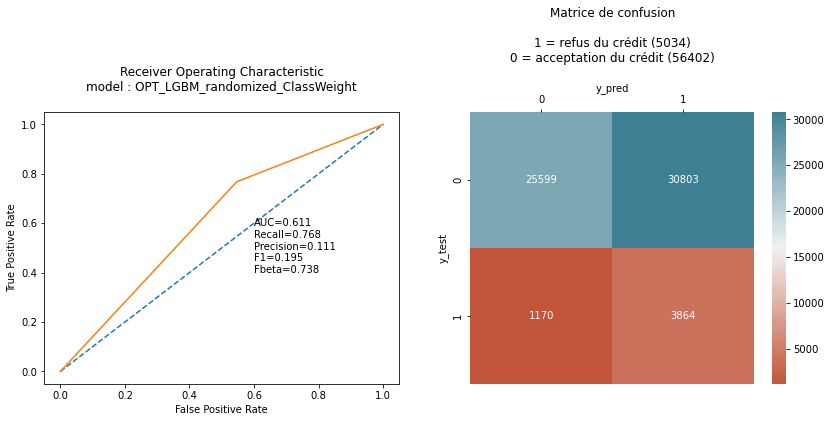

In [52]:
# configuration des paramètres
max_depth = randint(low=5, high=15)
num_leaves = randint(low=2, high=30)  # doit être inférieur à 2*max_depth
num_iterations = randint(low=100, high=10000)
learning_rate = uniform(0.001, 10)
reg_alpha = uniform(0.001, 100)
reg_lambda = uniform(0.001, 100)
min_split_gain = uniform(0.001, 10)

distribution_lgbm = {'lgbmclassifier__max_depth': max_depth,
                     'lgbmclassifier__num_leaves': num_leaves,
                     'lgbmclassifier__num_iterations': num_iterations,
                     'lgbmclassifier__learning_rate': learning_rate,
                     'lgbmclassifier__reg_alpha': reg_alpha,
                     'lgbmclassifier__reg_lambda': reg_lambda,
                     'lgbmclassifier__min_split_gain': min_split_gain}

# configuration modèle
model = LGBMClassifier(random_state=10, class_weight={0: 1, 1: weight_positive})
lgbm = make_pipeline(preprocessor, model)

randomized_lgbm_CW = RandomizedSearchCV(
    lgbm, param_distributions=distribution_lgbm, scoring=fbeta_scorer, cv=5, random_state=10, verbose=-1, n_iter=10)
resultats_optimisation, randomized_lgbm_CW_opt = optimisation_param(
    randomized_lgbm_CW, "OPT_LGBM_randomized_ClassWeight", X_train, y_train, X_test, y_test, resultats_optimisation)


In [53]:
resultats_optimisation


,best_params,AUC,Recall,Precision,F1,Fbeta,seuil_opt,duree_calculs_s,duree_refit
OPT_LogRef_randomized_smote,"{'logisticregression__C': 54.881450392732475, ...",0.752055,0.67799,0.165945,0.26663,0.663863,0.48037,292.989824,6.943973
OPT_LGBM_randomized_smote,{'lgbmclassifier__learning_rate': 7.5871562432...,0.621833,0.734207,0.114651,0.198331,0.707828,1.0,1031.265457,6.648723
OPT_LogRef_randomized_ClassWeight,"{'logisticregression__C': 60.27643760716439, '...",0.752927,0.663886,0.170241,0.270991,0.65087,0.464858,1537.918293,42.870639
OPT_LGBM_randomized_ClassWeight,{'lgbmclassifier__learning_rate': 3.6834153984...,0.610724,0.76758,0.11146,0.194655,0.737635,1.0,4305.954759,148.950099


# Fonction métier customisée
score = TN * gain - FP * gain - FN * perte + 0 * TP

Seuil optimal de discrimination:0.480

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56402
         1.0       0.17      0.68      0.27      5034

    accuracy                           0.69     61436
   macro avg       0.56      0.69      0.54     61436
weighted avg       0.90      0.69      0.76     61436

----------
f1-score : 0.267
fbeta-score : 0.664
precision : 0.166
recall : 0.678
auc : 0.752
-200144438.88922256


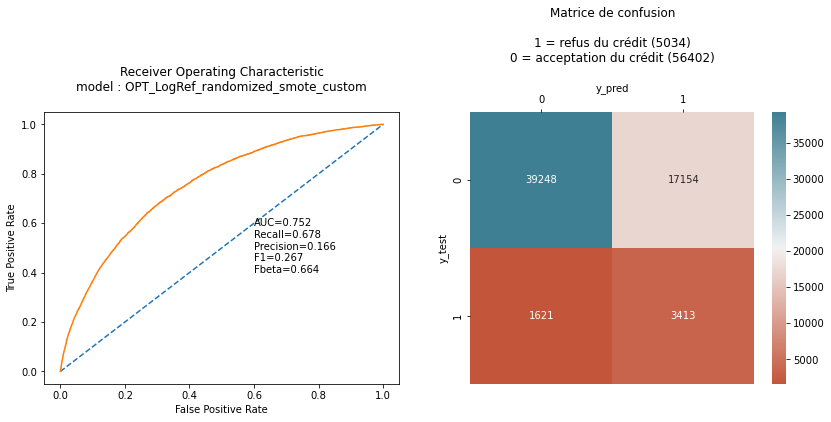

In [139]:
# configuration modèle
model = LogisticRegression(random_state=10)
lr = make_pipeline(preprocessor, model)

randomized_lr_smote = RandomizedSearchCV(
    lr, param_distributions=distribution_lr, scoring=custom_score, cv=5, random_state=10)
resultats_optimisation, randomized_lr_smote_opt_custom = optimisation_param(
    randomized_lr_smote, "OPT_LogRef_randomized_smote_custom", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)
print(randomized_lr_smote_opt_custom.best_score_)

In [141]:
resultats_optimisation

,best_params,AUC,Recall,Precision,F1,Fbeta,seuil_opt,duree_calculs_s,duree_refit
OPT_LGBM_randomized_smote_100,{'lgbmclassifier__learning_rate': 9.5953334083...,0.511625,0.951132,0.083819,0.154061,0.887779,0.678473,11293.518998,36.083042
OPT_LGBM_randomized_ClassWeight,{'lgbmclassifier__learning_rate': 3.6834153984...,0.610724,0.76758,0.11146,0.194655,0.737635,1.0,4305.954759,148.950099
OPT_LGBM_randomized_ClassWeight_100,{'lgbmclassifier__learning_rate': 3.6834153984...,0.610724,0.76758,0.11146,0.194655,0.737635,1.0,48197.419013,145.017642
OPT_LGBM_randomized_smote,{'lgbmclassifier__learning_rate': 7.5871562432...,0.621833,0.734207,0.114651,0.198331,0.707828,1.0,1031.265457,6.648723
OPT_LogRef_randomized_smote_100,"{'logisticregression__C': 87.26516554473953, '...",0.752137,0.679976,0.166165,0.267067,0.665778,0.500187,2046.45507,1.309133
OPT_LogRef_randomized_smote,"{'logisticregression__C': 54.881450392732475, ...",0.752055,0.67799,0.165945,0.26663,0.663863,0.48037,292.989824,6.943973
OPT_LogRef_randomized_ClassWeight,"{'logisticregression__C': 60.27643760716439, '...",0.752927,0.663886,0.170241,0.270991,0.65087,0.464858,1537.918293,42.870639
OPT_LogRef_randomized_ClassWeight_100,"{'logisticregression__C': 38.34632250349479, '...",0.752913,0.660906,0.169589,0.269917,0.64796,0.464682,10477.954104,6.326089
OPT_LogRef_randomized_smote_beta6,"{'logisticregression__C': 54.881450392732475, ...",0.752055,0.67799,0.165945,0.26663,0.625801,0.48037,383.704306,9.20827
OPT_LGBM_randomized_smote_beta6,{'lgbmclassifier__learning_rate': 7.5871562432...,0.621833,0.734207,0.114651,0.198331,0.640642,1.0,1409.896676,8.210696


Seuil optimal de discrimination:0.359

              precision    recall  f1-score   support

         0.0       0.95      0.13      0.23     56402
         1.0       0.09      0.92      0.16      5034

    accuracy                           0.20     61436
   macro avg       0.52      0.53      0.19     61436
weighted avg       0.88      0.20      0.22     61436

----------
f1-score : 0.158
fbeta-score : 0.863
precision : 0.086
recall : 0.920
auc : 0.517
3946868.629601985


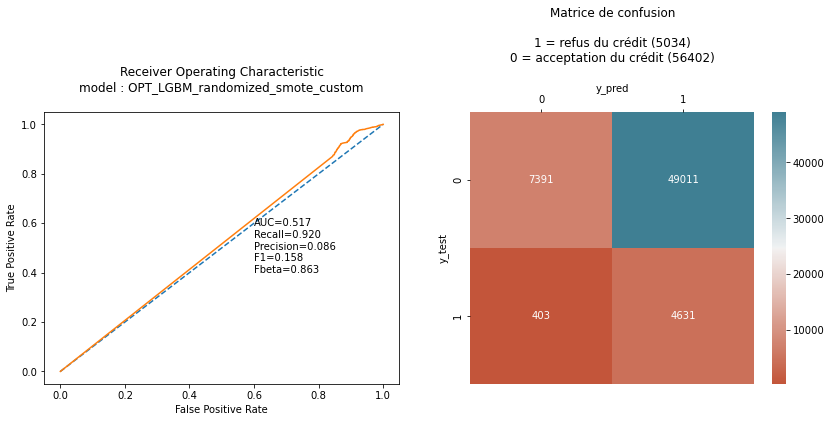

In [142]:
# configuration modèle
model = LGBMClassifier(random_state=10)
lgbm = make_pipeline(preprocessor, model)

randomized_lgbm_smote = RandomizedSearchCV(
    lgbm, param_distributions=distribution_lgbm, scoring=custom_score, cv=5, random_state=10, verbose=-1, n_iter=10)
resultats_optimisation, randomized_lgbm_smote_opt_custom = optimisation_param(
    randomized_lgbm_smote, "OPT_LGBM_randomized_smote_custom", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)
print(randomized_lgbm_smote_opt_custom.best_score_)

In [143]:
resultats_optimisation

,best_params,AUC,Recall,Precision,F1,Fbeta,seuil_opt,duree_calculs_s,duree_refit
OPT_LGBM_randomized_smote_100,{'lgbmclassifier__learning_rate': 9.5953334083...,0.511625,0.951132,0.083819,0.154061,0.887779,0.678473,11293.518998,36.083042
OPT_LGBM_randomized_ClassWeight,{'lgbmclassifier__learning_rate': 3.6834153984...,0.610724,0.76758,0.11146,0.194655,0.737635,1.0,4305.954759,148.950099
OPT_LGBM_randomized_ClassWeight_100,{'lgbmclassifier__learning_rate': 3.6834153984...,0.610724,0.76758,0.11146,0.194655,0.737635,1.0,48197.419013,145.017642
OPT_LGBM_randomized_smote,{'lgbmclassifier__learning_rate': 7.5871562432...,0.621833,0.734207,0.114651,0.198331,0.707828,1.0,1031.265457,6.648723
OPT_LogRef_randomized_smote_100,"{'logisticregression__C': 87.26516554473953, '...",0.752137,0.679976,0.166165,0.267067,0.665778,0.500187,2046.45507,1.309133
OPT_LogRef_randomized_smote,"{'logisticregression__C': 54.881450392732475, ...",0.752055,0.67799,0.165945,0.26663,0.663863,0.48037,292.989824,6.943973
OPT_LogRef_randomized_ClassWeight,"{'logisticregression__C': 60.27643760716439, '...",0.752927,0.663886,0.170241,0.270991,0.65087,0.464858,1537.918293,42.870639
OPT_LogRef_randomized_ClassWeight_100,"{'logisticregression__C': 38.34632250349479, '...",0.752913,0.660906,0.169589,0.269917,0.64796,0.464682,10477.954104,6.326089
OPT_LogRef_randomized_smote_beta6,"{'logisticregression__C': 54.881450392732475, ...",0.752055,0.67799,0.165945,0.26663,0.625801,0.48037,383.704306,9.20827
OPT_LGBM_randomized_smote_beta6,{'lgbmclassifier__learning_rate': 7.5871562432...,0.621833,0.734207,0.114651,0.198331,0.640642,1.0,1409.896676,8.210696


In [ ]:
# configuration modèle
model = LogisticRegression(random_state=10, class_weight={
                           0: 1, 1: weight_positive})
lr = make_pipeline(preprocessor, model)

randomized_lr_CW = RandomizedSearchCV(
    lr, param_distributions=distribution_lr, scoring=custom_score, cv=5, random_state=10)
resultats_optimisation, randomized_lr_CW_opt_custom = optimisation_param(
    randomized_lr_CW, "OPT_LogRef_randomized_ClassWeight_custom", X_train, y_train, X_test, y_test, resultats_optimisation)

print(randomized_lr_CW_opt_custom.best_score_)

In [ ]:
# configuration modèle
model = LGBMClassifier(random_state=10, class_weight={0: 1, 1: weight_positive})
lgbm = make_pipeline(preprocessor, model)

randomized_lgbm_CW = RandomizedSearchCV(
    lgbm, param_distributions=distribution_lgbm, scoring=custom_score, cv=5, random_state=10, verbose=-1, n_iter=10)
resultats_optimisation, randomized_lgbm_CW_opt_custom = optimisation_param(
    randomized_lgbm_CW, "OPT_LGBM_randomized_ClassWeight_custom", X_train, y_train, X_test, y_test, resultats_optimisation)

print(randomized_lgbm_CW_opt_custom.best_score_)


# Optimisation avec n_iter = 50

Seuil optimal de discrimination:0.500

              precision    recall  f1-score   support

         0.0       0.96      0.70      0.81     56402
         1.0       0.17      0.68      0.27      5034

    accuracy                           0.69     61436
   macro avg       0.56      0.69      0.54     61436
weighted avg       0.90      0.69      0.76     61436

----------
f1-score : 0.267
fbeta-score : 0.666
precision : 0.166
recall : 0.680
auc : 0.752


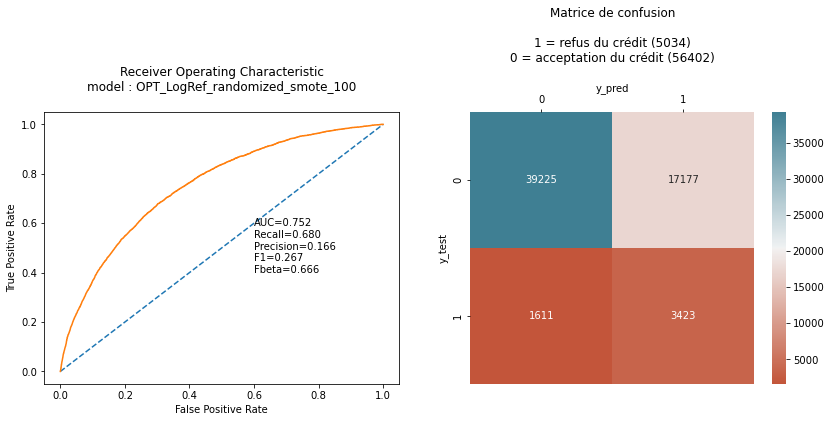

In [54]:
# test avec randomizedSearchCV
distribution_lr = {'logisticregression__penalty': penalty,
                   'logisticregression__C': C,
                   'logisticregression__solver': solver}

# configuration modèle
model = LogisticRegression(random_state=10)
lr = make_pipeline(preprocessor, model)

randomized_lr_smote = RandomizedSearchCV(
    lr, param_distributions=distribution_lr, scoring=fbeta_scorer, cv=5, random_state=10, n_iter=50)
resultats_optimisation, randomized_lr_smote_opt_50 = optimisation_param(
    randomized_lr_smote, "OPT_LogRef_randomized_smote_50", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)


Seuil optimal de discrimination:0.678

              precision    recall  f1-score   support

         0.0       0.94      0.07      0.13     56402
         1.0       0.08      0.95      0.15      5034

    accuracy                           0.14     61436
   macro avg       0.51      0.51      0.14     61436
weighted avg       0.87      0.14      0.14     61436

----------
f1-score : 0.154
fbeta-score : 0.888
precision : 0.084
recall : 0.951
auc : 0.512


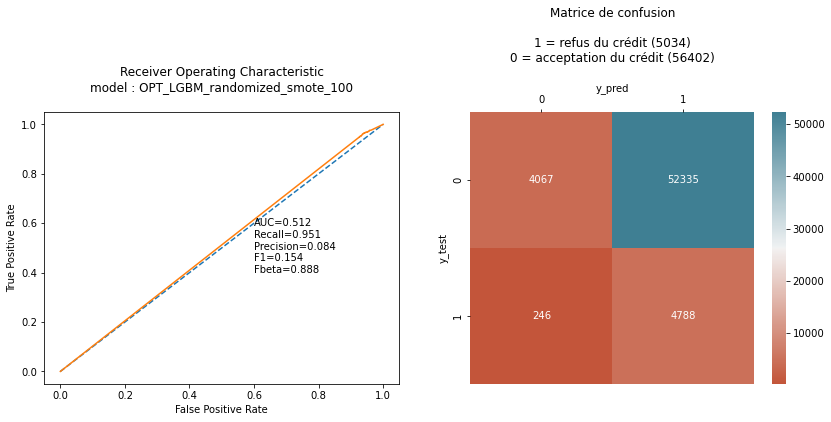

In [55]:
distribution_lgbm = {'lgbmclassifier__max_depth': max_depth,
                     'lgbmclassifier__num_leaves': num_leaves,
                     'lgbmclassifier__num_iterations': num_iterations,
                     'lgbmclassifier__learning_rate': learning_rate,
                     'lgbmclassifier__reg_alpha': reg_alpha,
                     'lgbmclassifier__reg_lambda': reg_lambda,
                     'lgbmclassifier__min_split_gain': min_split_gain}

# configuration modèle
model = LGBMClassifier(random_state=10)
lgbm = make_pipeline(preprocessor, model)

randomized_lgbm_smote = RandomizedSearchCV(
    lgbm, param_distributions=distribution_lgbm, scoring=fbeta_scorer, cv=5, random_state=10, verbose=-1, n_iter=50)
resultats_optimisation, randomized_lgbm_smote_opt_50 = optimisation_param(
    randomized_lgbm_smote, "OPT_LGBM_randomized_smote_50", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)


Seuil optimal de discrimination:0.465

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.82     56402
         1.0       0.17      0.66      0.27      5034

    accuracy                           0.71     61436
   macro avg       0.56      0.69      0.54     61436
weighted avg       0.89      0.71      0.77     61436

----------
f1-score : 0.270
fbeta-score : 0.648
precision : 0.170
recall : 0.661
auc : 0.753


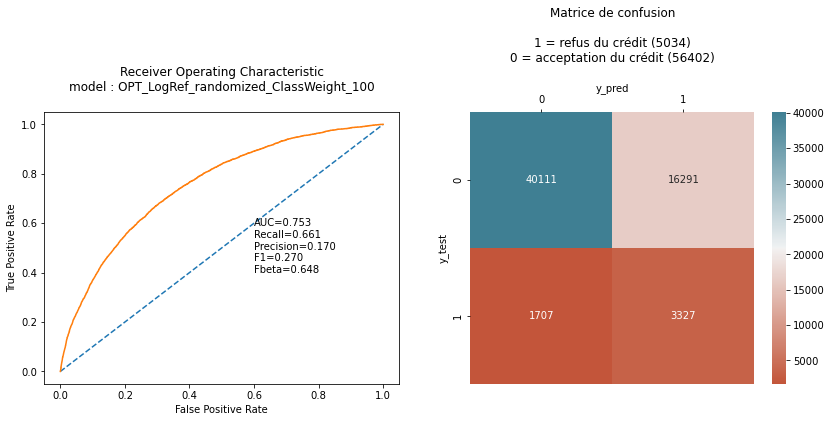

In [56]:
# configuration des paramètres à tester
distribution_lr = {'logisticregression__penalty': penalty,
                   'logisticregression__C': C,
                   'logisticregression__solver': solver}

# configuration modèle
model = LogisticRegression(random_state=10, class_weight={
                           0: 1, 1: weight_positive})
lr = make_pipeline(preprocessor, model)

randomized_lr_CW = RandomizedSearchCV(
    lr, param_distributions=distribution_lr, scoring=fbeta_scorer, cv=5, random_state=10, n_iter=50)
resultats_optimisation, randomized_lr_CW_opt_50 = optimisation_param(
    randomized_lr_CW, "OPT_LogRef_randomized_ClassWeight_50", X_train, y_train, X_test, y_test, resultats_optimisation)


Seuil optimal de discrimination:1.000

              precision    recall  f1-score   support

         0.0       0.96      0.45      0.62     56402
         1.0       0.11      0.77      0.19      5034

    accuracy                           0.48     61436
   macro avg       0.53      0.61      0.41     61436
weighted avg       0.89      0.48      0.58     61436

----------
f1-score : 0.195
fbeta-score : 0.738
precision : 0.111
recall : 0.768
auc : 0.611


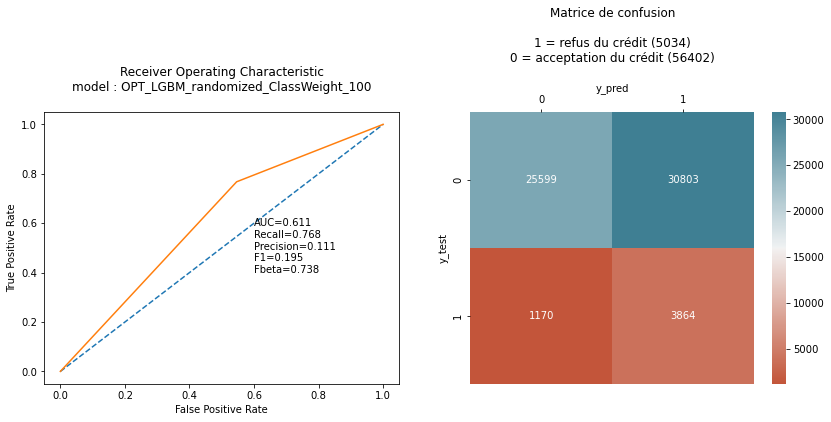

In [57]:
distribution_lgbm = {'lgbmclassifier__max_depth': max_depth,
                     'lgbmclassifier__num_leaves': num_leaves,
                     'lgbmclassifier__num_iterations': num_iterations,
                     'lgbmclassifier__learning_rate': learning_rate,
                     'lgbmclassifier__reg_alpha': reg_alpha,
                     'lgbmclassifier__reg_lambda': reg_lambda,
                     'lgbmclassifier__min_split_gain': min_split_gain}

# configuration modèle
model = LGBMClassifier(random_state=10, class_weight={0: 1, 1: weight_positive})
lgbm = make_pipeline(preprocessor, model)

randomized_lgbm_CW = RandomizedSearchCV(
    lgbm, param_distributions=distribution_lgbm, scoring=fbeta_scorer, cv=5, random_state=10, verbose=-1, n_iter=50)
resultats_optimisation, randomized_lgbm_CW_opt_50 = optimisation_param(
    randomized_lgbm_CW, "OPT_LGBM_randomized_ClassWeight_50", X_train, y_train, X_test, y_test, resultats_optimisation)


In [77]:
resultats_optimisation = resultats_optimisation.sort_values(by='Fbeta', ascending=False)
resultats_optimisation

,best_params,AUC,Recall,Precision,F1,Fbeta,seuil_opt,duree_calculs_s,duree_refit
OPT_LGBM_randomized_smote_100,{'lgbmclassifier__learning_rate': 9.5953334083...,0.511625,0.951132,0.083819,0.154061,0.887779,0.678473,11293.518998,36.083042
OPT_LGBM_randomized_ClassWeight,{'lgbmclassifier__learning_rate': 3.6834153984...,0.610724,0.76758,0.11146,0.194655,0.737635,1.0,4305.954759,148.950099
OPT_LGBM_randomized_ClassWeight_100,{'lgbmclassifier__learning_rate': 3.6834153984...,0.610724,0.76758,0.11146,0.194655,0.737635,1.0,48197.419013,145.017642
OPT_LGBM_randomized_smote,{'lgbmclassifier__learning_rate': 7.5871562432...,0.621833,0.734207,0.114651,0.198331,0.707828,1.0,1031.265457,6.648723
OPT_LogRef_randomized_smote_100,"{'logisticregression__C': 87.26516554473953, '...",0.752137,0.679976,0.166165,0.267067,0.665778,0.500187,2046.45507,1.309133
OPT_LogRef_randomized_smote,"{'logisticregression__C': 54.881450392732475, ...",0.752055,0.67799,0.165945,0.26663,0.663863,0.48037,292.989824,6.943973
OPT_LogRef_randomized_ClassWeight,"{'logisticregression__C': 60.27643760716439, '...",0.752927,0.663886,0.170241,0.270991,0.65087,0.464858,1537.918293,42.870639
OPT_LogRef_randomized_ClassWeight_100,"{'logisticregression__C': 38.34632250349479, '...",0.752913,0.660906,0.169589,0.269917,0.64796,0.464682,10477.954104,6.326089


In [80]:
for i in range(len(resultats_optimisation)):
    print('-'*10)
    print(resultats_optimisation.index[i], ':', resultats_optimisation.Fbeta[i])
    print(resultats_optimisation.best_params[i])

----------
OPT_LGBM_randomized_smote_100 : 0.8877789414323691
{'lgbmclassifier__learning_rate': 9.59533340833425, 'lgbmclassifier__max_depth': 6, 'lgbmclassifier__min_split_gain': 4.75389441908616, 'lgbmclassifier__num_iterations': 6934, 'lgbmclassifier__num_leaves': 15, 'lgbmclassifier__reg_alpha': 51.00268523182502, 'lgbmclassifier__reg_lambda': 53.6187494703452}
----------
OPT_LGBM_randomized_ClassWeight : 0.7376346662488826
{'lgbmclassifier__learning_rate': 3.68341539840548, 'lgbmclassifier__max_depth': 10, 'lgbmclassifier__min_split_gain': 7.782567509498505, 'lgbmclassifier__num_iterations': 7699, 'lgbmclassifier__num_leaves': 2, 'lgbmclassifier__reg_alpha': 97.86283422327641, 'lgbmclassifier__reg_lambda': 79.91685642167236}
----------
OPT_LGBM_randomized_ClassWeight_100 : 0.7376346662488826
{'lgbmclassifier__learning_rate': 3.68341539840548, 'lgbmclassifier__max_depth': 10, 'lgbmclassifier__min_split_gain': 7.782567509498505, 'lgbmclassifier__num_iterations': 7699, 'lgbmclassifie

# Choix modèle

# Feature importance

In [81]:
# choix modèle pour tester :
best_model = randomized_lr_smote_opt.best_estimator_[1]

In [72]:
def feature_importance_LGBM(model, nb_features_to_plot):
    best_model = model.best_estimator_[1]
    nom_features = model.feature_names_in_
    print(best_model.feature_importances_)
    feature_importance = pd.DataFrame(best_model.feature_importances_, index=nom_features, columns=['score'])
    feature_importance = feature_importance.sort_values(by='score', ascending=False).reset_index()
    print(feature_importance)
    top = feature_importance.head(nb_features_to_plot)
    hauteur = int(top.shape[0]/4)
    fig = plt.figure(figsize=(8, hauteur))
    sns.barplot(data=top, x='score', y='index')

def feature_importance_LR(model, nb_features_to_plot):
    best_model = model.best_estimator_[1]
    nom_features = model.feature_names_in_
    feature_importance = pd.DataFrame(best_model.coef_, columns=nom_features, index=['score']).T
    feature_importance = feature_importance.sort_values(by='score', ascending=False).reset_index()
    top = feature_importance.head(nb_features_to_plot)
    hauteur = int(top.shape[0]/4)
    fig = plt.figure(figsize=(8, hauteur))
    sns.barplot(data=top, x='score', y='index')

[   12  4892   159    12    34    18   135  5110     1     2     0    11
  2802 12661    11  1884    19  4820     2    29   889    52    11     8
  5590     9   538    10     7     5     0   375    17     0   149    16
    10     4     0     0    28     5     3   100    31     3    44     5
     6     0     5     2    61     0    63    17     4    49     0     0
     0     0     0     1     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     8
     9     0     0   464     6    14     0     0     0     2    10     0
     0    26     0     9    58    19     5     6     6     0     3    10
  1556     5     1     6     2     0     0     0     0     1     0     0
     0     0     0     0     0]
                                              index  score
0                                   FLAG_WORK_PHONE  12661
1                                   FLAG_DOCUMENT_3   5590
2                                   AMT_GOODS_PRICE   5110
3 

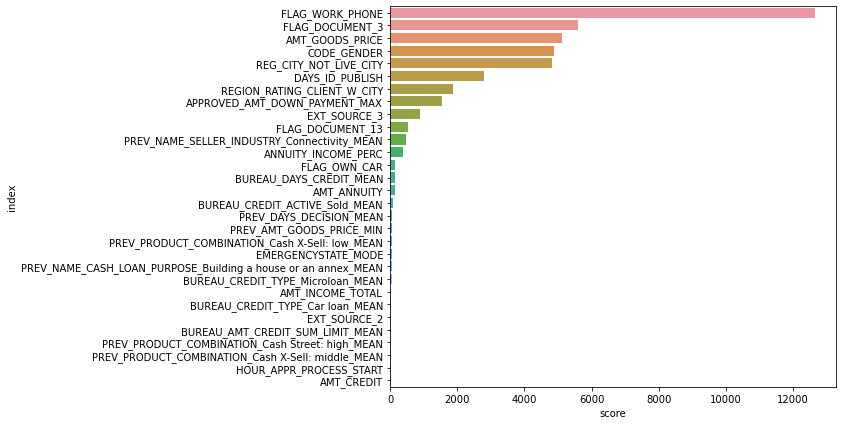

In [74]:
feature_importance_LGBM(randomized_lgbm_smote_opt, 30)

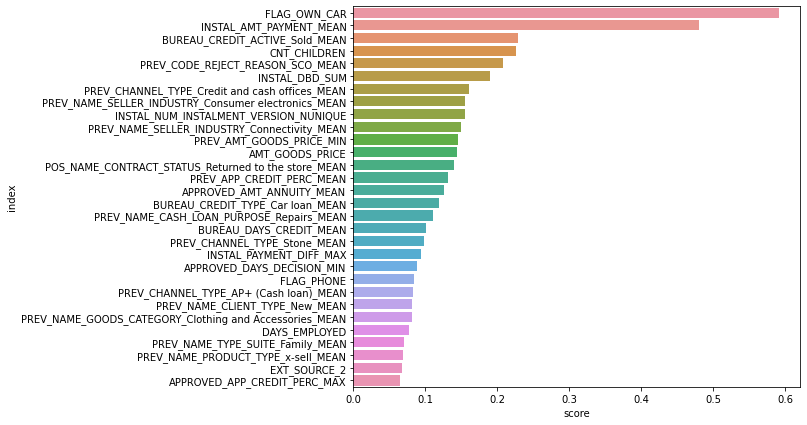

In [82]:
feature_importance_LR(randomized_lr_smote_opt, 30)

# Choix du seuil de décision

In [83]:
model = randomized_lr_smote_opt
y_proba = model.predict_proba(X_test)[:, 1]
masque = y_proba > 0.45
masque
y_pred = y_proba.copy()
y_pred[masque] = 1
y_pred[~masque] = 0
pd.DataFrame(y_pred).value_counts()
fbeta_score(y_test, y_pred, beta=12)

0.721705802781728

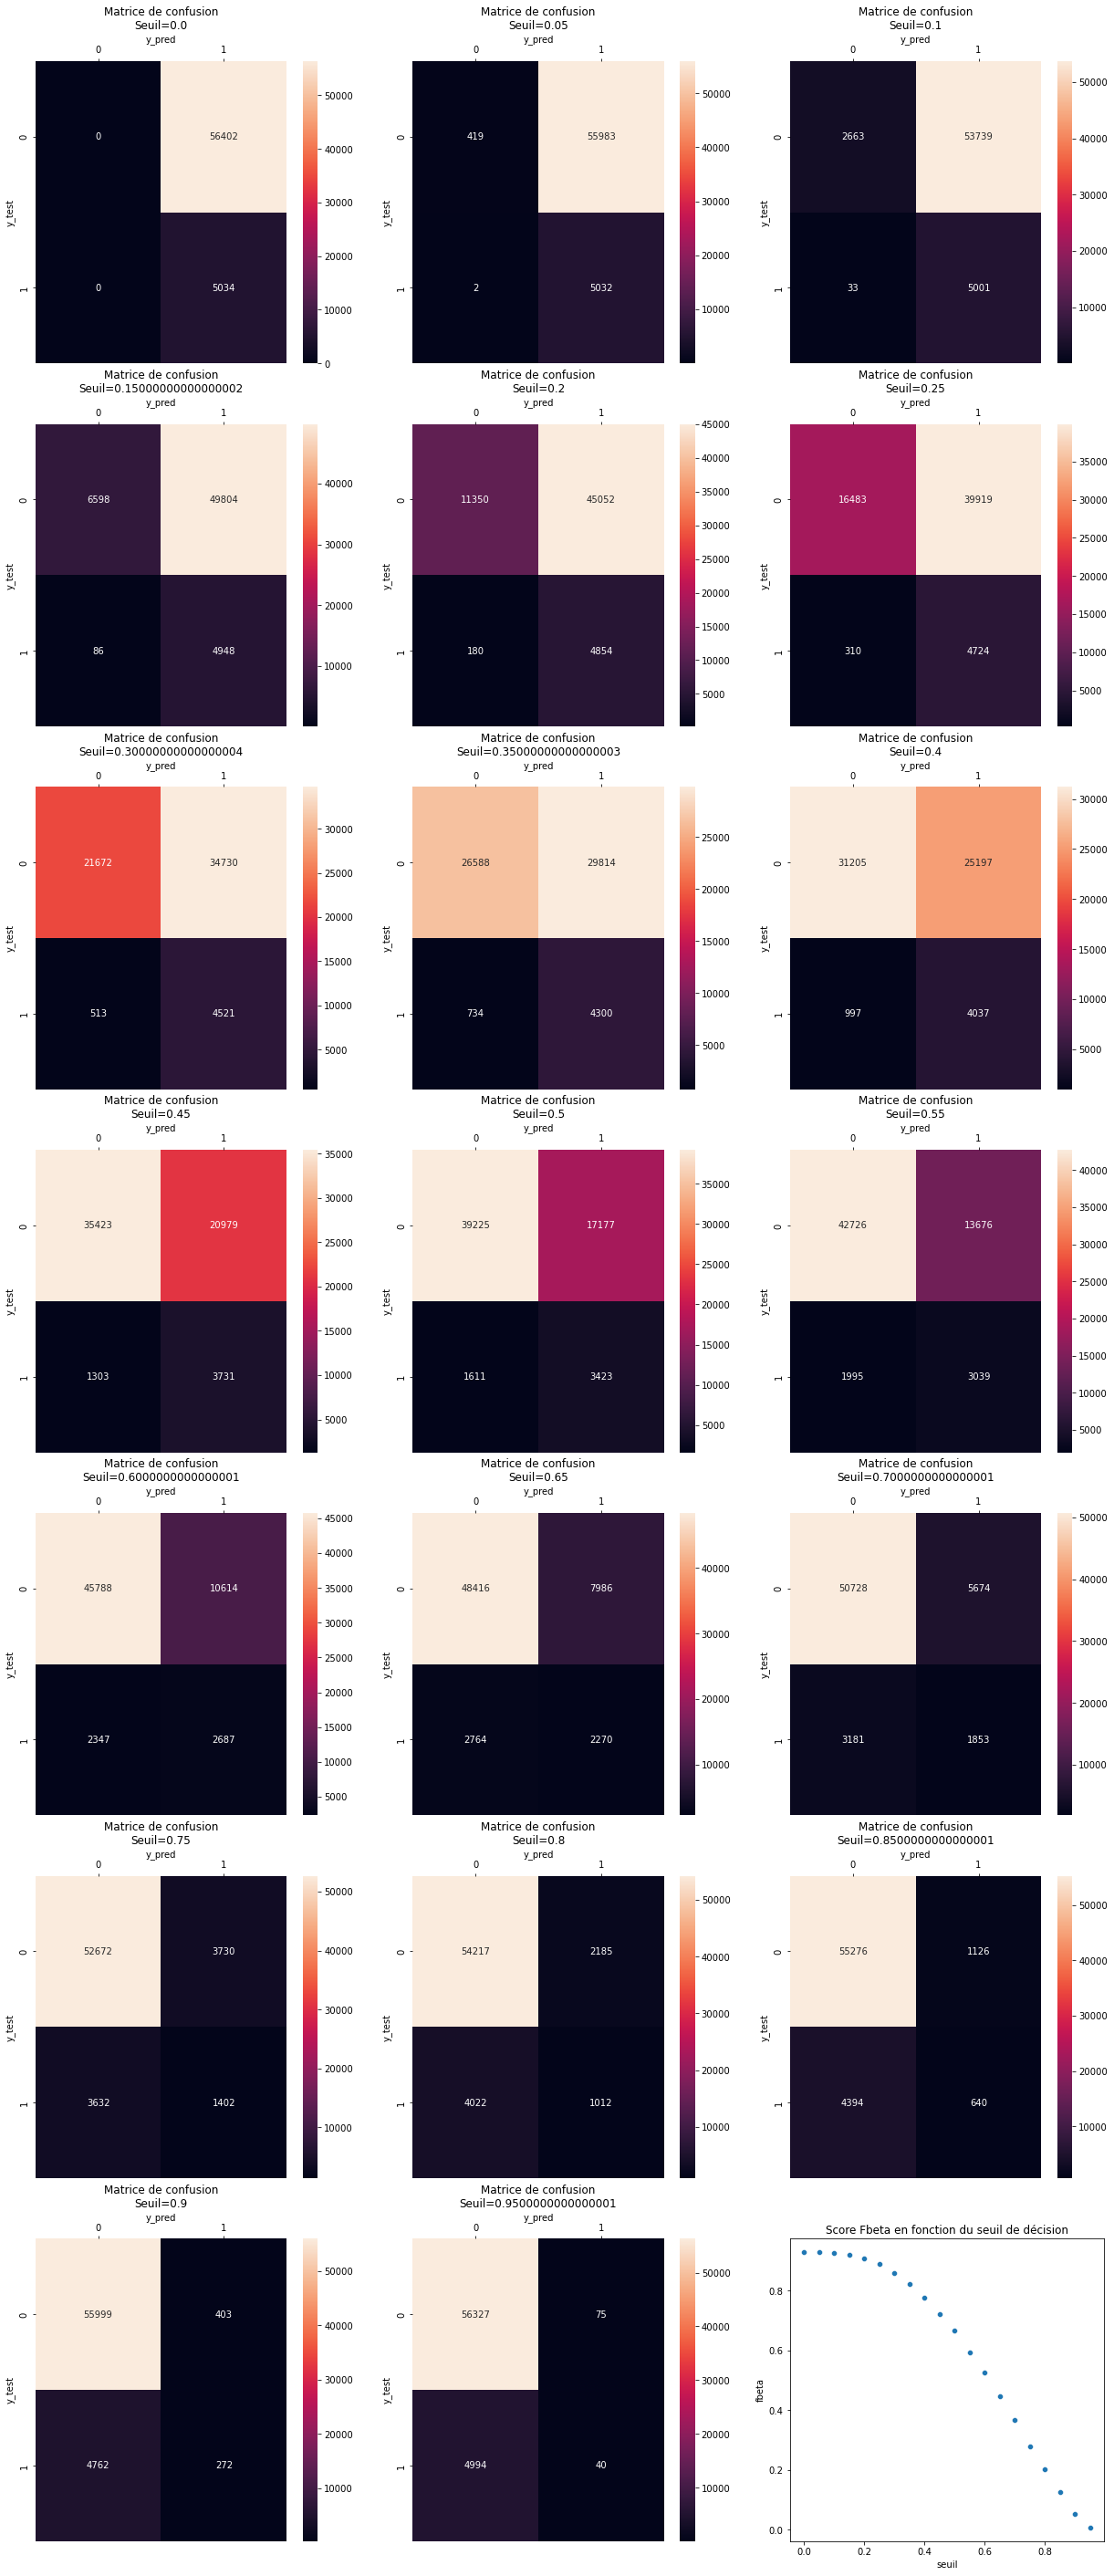

In [99]:
model = randomized_lr_smote_opt
y_proba = model.predict_proba(X_test)[:, 1]
choix_seuil = pd.DataFrame()
plt.figure(figsize=(21,50))
compteur = 1
for seuil in np.arange(0, 1, 0.05):
    masque = y_proba > seuil
    y_pred = y_proba.copy()
    y_pred[masque] = 1
    y_pred[~masque] = 0
    score = fbeta_score(y_test, y_pred, beta=12)
    result = pd.DataFrame([seuil, score]).T
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.subplot(7,3,compteur)
    axes = plt.gca()
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.title("Matrice de confusion\nSeuil={}".format(seuil))
    axes.xaxis.set_ticks_position('top')
    axes.xaxis.set_label_position('top')
    axes.set_frame_on('False')
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    compteur += 1
    choix_seuil = choix_seuil.append(result)

choix_seuil.columns = ['seuil', 'fbeta']
choix_seuil = choix_seuil.reset_index(drop=True)
plt.subplot(7,3,21)
sns.scatterplot(data=choix_seuil, x='seuil', y='fbeta')
plt.title('Score Fbeta en fonction du seuil de décision')
plt.show()

In [111]:
model = randomized_lr_smote_opt
y_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
test = pd.DataFrame(y_proba, y_pred)
test[test<0.5].mean()

print(sum(y_proba > 0.5))
sum(y_pred)

20600


20600.0